# Đánh giá hiệu suất của các mô hình kết hợp

### Bước 1: Chuẩn bị môi trường và dữ liệu

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from time import process_time
import math
import warnings

# Tắt cảnh báo để tránh thông báo không cần thiết
warnings.filterwarnings('ignore')

# Đặt random seed để đảm bảo kết quả tái tạo
np.random.seed(10)

Tải dữ liệu CIC-IDS2017 (giả định dữ liệu)

Nếu bạn có dữ liệu thực tế, hãy thay thế đoạn này bằng code tải dữ liệu của bạn

Ví dụ: ids2017 = pd.read_csv('path_to_ids2017.csv')

In [1]:
# Để kiểm tra, tôi sẽ tạo dữ liệu giả định
from sklearn.datasets import make_classification
ids2017_X, ids2017_y = make_classification(n_samples=50000, n_features=20, n_classes=2, random_state=10)

# Chia dữ liệu CIC-IDS2017 thành tập huấn luyện và kiểm tra
ids2017_train_X, ids2017_test_X, ids2017_train_y, ids2017_test_y = train_test_split(
    ids2017_X, ids2017_y, test_size=0.2, random_state=10
)

# Chuẩn hóa dữ liệu CIC-IDS2017
scaler = StandardScaler()
ids2017_train_X_scaled = scaler.fit_transform(ids2017_train_X)
ids2017_test_X_scaled = scaler.transform(ids2017_test_X)

# Tải dữ liệu CSE-CIC-IDS2018 (giả định dữ liệu)
# Nếu bạn có dữ liệu thực tế, hãy thay thế đoạn này bằng code tải dữ liệu của bạn
# Ví dụ: ids2018 = pd.read_csv('path_to_ids2018.csv')
ids2018_X, ids2018_y = make_classification(n_samples=20000, n_features=20, n_classes=2, random_state=10)

# Chuẩn hóa dữ liệu CSE-CIC-IDS2018
ids2018_X_scaled = scaler.transform(ids2018_X)

# Kiểm tra dữ liệu
print("CIC-IDS2017:")
print("Kích thước tập huấn luyện (X):", ids2017_train_X_scaled.shape)
print("Kích thước tập kiểm tra (X):", ids2017_test_X_scaled.shape)
print("Kích thước nhãn huấn luyện (y):", ids2017_train_y.shape)
print("Kích thước nhãn kiểm tra (y):", ids2017_test_y.shape)
print("Ví dụ nhãn huấn luyện:", ids2017_train_y[:5])

print("\nCSE-CIC-IDS2018:")
print("Kích thước dữ liệu đầu vào (X):", ids2018_X_scaled.shape)
print("Kích thước nhãn (y):", ids2018_y.shape)
print("Ví dụ nhãn:", ids2018_y[:5])

CIC-IDS2017:
Kích thước tập huấn luyện (X): (40000, 20)
Kích thước tập kiểm tra (X): (10000, 20)
Kích thước nhãn huấn luyện (y): (40000,)
Kích thước nhãn kiểm tra (y): (10000,)
Ví dụ nhãn huấn luyện: [1 0 0 1 0]

CSE-CIC-IDS2018:
Kích thước dữ liệu đầu vào (X): (20000, 20)
Kích thước nhãn (y): (20000,)
Ví dụ nhãn: [1 1 1 1 0]


### Bước 2 (Điều chỉnh): Tạo và huấn luyện các mô hình kết hợp trên tập CIC-IDS2017 và CIC-IDS2018 với tham số tối ưu

In [13]:
# Khởi tạo các mô hình cơ bản với tham số tối ưu
rf = RandomForestClassifier(max_depth=20, min_samples_leaf=0.00001, min_samples_split=0.00001, 
                            n_estimators=350, n_jobs=-1, criterion='gini', random_state=10)
xgb = XGBClassifier(random_state=10, eval_metric='logloss')  # XGBoost chưa có tham số tối ưu từ trước, giữ mặc định
svm = SVC(C=100, gamma=1, kernel='rbf', probability=True, random_state=10)
nb = GaussianNB(var_smoothing=1.0)
ann = MLPClassifier(hidden_layer_sizes=(50,), activation='tanh', alpha=0.0001, 
                    solver='adam', max_iter=1000, random_state=10)
dnn = MLPClassifier(hidden_layer_sizes=(15, 15, 15), activation='tanh', alpha=1e-05, 
                    solver='adam', max_iter=1000, random_state=10)

# Tạo 6 mô hình (5 mô hình kết hợp + 1 mô hình RandomForest đơn lẻ)
models = {
    'RandomForest + XGBoost': VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft'),
    'RandomForest + SVM': VotingClassifier(estimators=[('rf', rf), ('svm', svm)], voting='soft'),
    'RandomForest + Naive Bayes': VotingClassifier(estimators=[('rf', rf), ('nb', nb)], voting='soft'),
    'RandomForest + ANN': VotingClassifier(estimators=[('rf', rf), ('ann', ann)], voting='soft'),
    'RandomForest + Deep ANN': VotingClassifier(estimators=[('rf', rf), ('dnn', dnn)], voting='soft'),
    'RandomForest (Solo)': rf
}

# Huấn luyện các mô hình
trained_models = {}
training_time = {}

for model_name, clf in models.items():
    print(f"Đang huấn luyện: {model_name}")
    start_time = process_time()
    clf.fit(ids2017_train_X_scaled, ids2017_train_y)
    training_time[model_name] = process_time() - start_time
    trained_models[model_name] = clf
    print(f"Thời gian huấn luyện {model_name}: {training_time[model_name]:.2f} giây")

# Kiểm tra số lượng mô hình đã huấn luyện
print("\nSố lượng mô hình đã huấn luyện:", len(trained_models))
print("Các mô hình:", list(trained_models.keys()))

Đang huấn luyện: RandomForest + XGBoost
Thời gian huấn luyện RandomForest + XGBoost: 110.02 giây
Đang huấn luyện: RandomForest + SVM
Thời gian huấn luyện RandomForest + SVM: 1054.11 giây
Đang huấn luyện: RandomForest + Naive Bayes
Thời gian huấn luyện RandomForest + Naive Bayes: 114.05 giây
Đang huấn luyện: RandomForest + ANN
Thời gian huấn luyện RandomForest + ANN: 346.34 giây
Đang huấn luyện: RandomForest + Deep ANN
Thời gian huấn luyện RandomForest + Deep ANN: 137.36 giây
Đang huấn luyện: RandomForest (Solo)
Thời gian huấn luyện RandomForest (Solo): 111.44 giây

Số lượng mô hình đã huấn luyện: 6
Các mô hình: ['RandomForest + XGBoost', 'RandomForest + SVM', 'RandomForest + Naive Bayes', 'RandomForest + ANN', 'RandomForest + Deep ANN', 'RandomForest (Solo)']


### Bước 3: Đánh giá các mô hình trên tập kiểm tra CIC-IDS2017 và vẽ ma trận nhầm lẫn

------------------------- RandomForest + XGBoost -------------------------
              precision    recall  f1-score   support

           0     0.9472    0.8837    0.9144      4996
           1     0.8912    0.9508    0.9200      5004

    accuracy                         0.9173     10000
   macro avg     0.9192    0.9173    0.9172     10000
weighted avg     0.9192    0.9173    0.9172     10000

------------------------- RandomForest + SVM -------------------------
              precision    recall  f1-score   support

           0     0.9446    0.8837    0.9131      4996
           1     0.8909    0.9482    0.9187      5004

    accuracy                         0.9160     10000
   macro avg     0.9177    0.9160    0.9159     10000
weighted avg     0.9177    0.9160    0.9159     10000

------------------------- RandomForest + Naive Bayes -------------------------
              precision    recall  f1-score   support

           0     0.9494    0.8719    0.9090      4996
           1

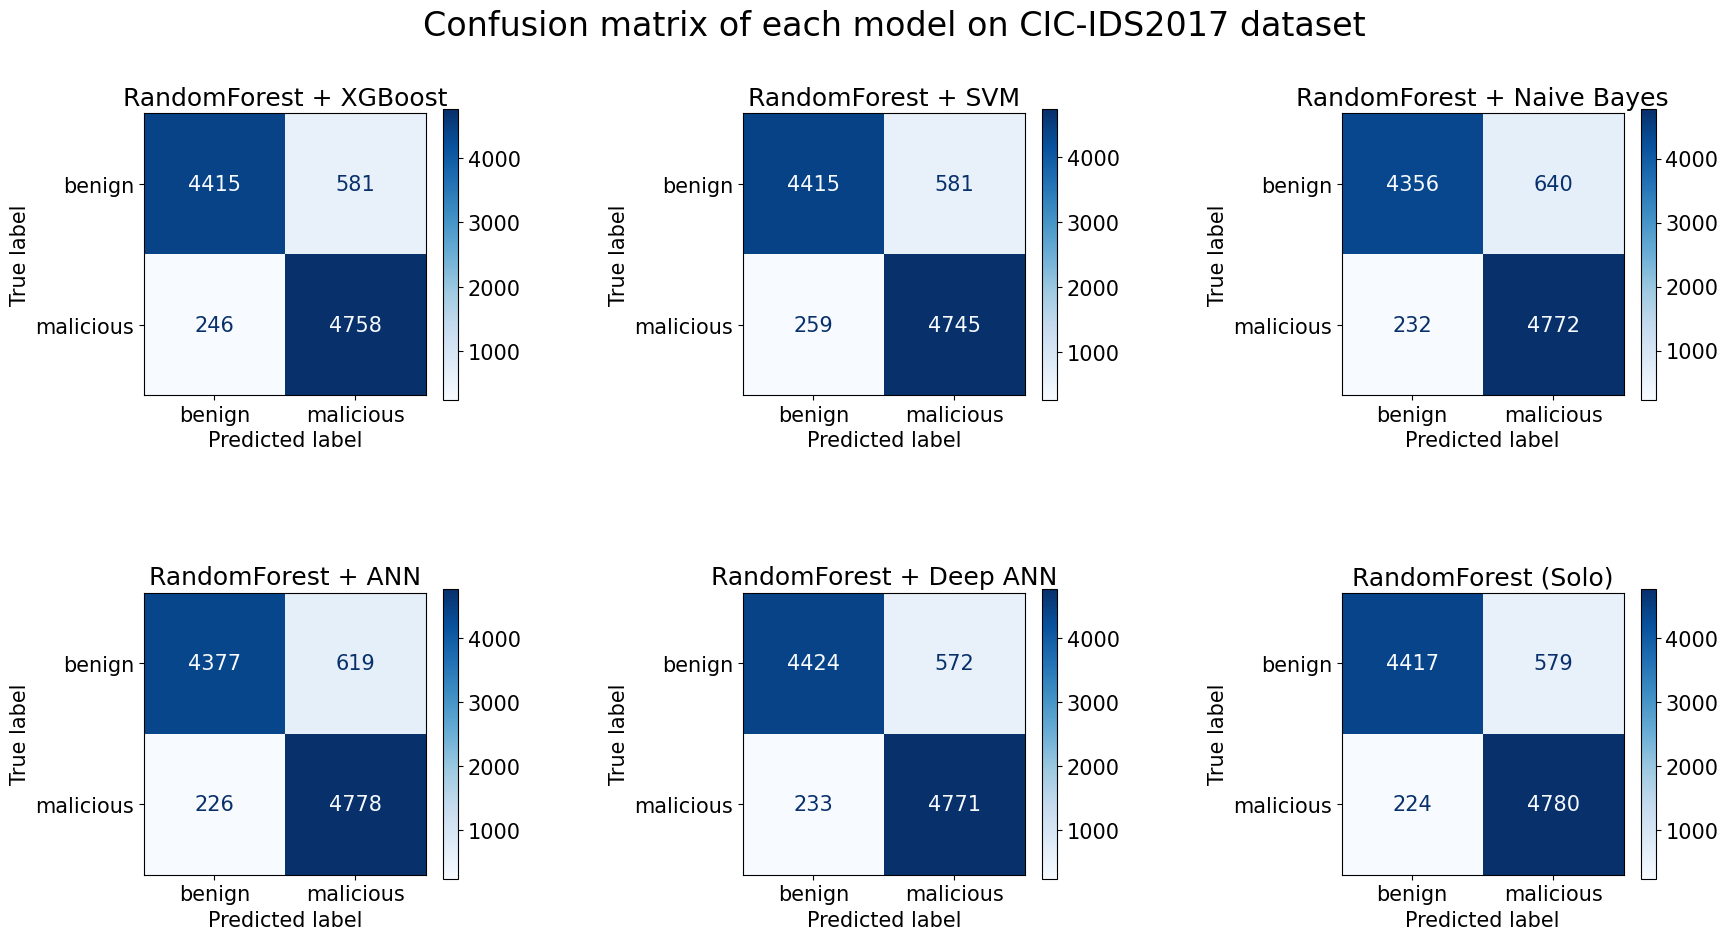


Thời gian dự đoán của từng mô hình:
RandomForest + XGBoost: 0.48 giây
RandomForest + SVM: 35.08 giây
RandomForest + Naive Bayes: 0.47 giây
RandomForest + ANN: 0.67 giây
RandomForest + Deep ANN: 1.12 giây
RandomForest (Solo): 1.12 giây


In [15]:
# Đóng tất cả các biểu đồ trước đó để tránh trùng lặp
plt.close('all')

# Khởi tạo các biến để lưu kết quả
prediction_time = {}
accuracy_testing_dataset = {}
f_score_testing_dataset = {}

# Tạo bố cục 2 hàng 3 cột để chứa 6 mô hình
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, (model, clf) in enumerate(trained_models.items()):
    # Đo thời gian dự đoán
    prediction_start_time = process_time()
    prediction = clf.predict(ids2017_test_X_scaled)
    prediction_time[model] = process_time() - prediction_start_time

    # Tính toán báo cáo phân loại
    model_report = classification_report(ids2017_test_y, prediction, digits=4, output_dict=True)

    # Lưu accuracy và f1-score
    accuracy_testing_dataset[model] = model_report['accuracy']
    f_score_testing_dataset[model] = model_report['weighted avg']['f1-score']

    # In báo cáo phân loại
    print(f"{'-'*25} {model} {'-'*25}")
    print(classification_report(ids2017_test_y, prediction, digits=4))

    # Vẽ ma trận nhầm lẫn
    cm = confusion_matrix(ids2017_test_y, prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malicious'])
    disp.plot(ax=axes[math.floor(i/3)][i%3], cmap=plt.cm.Blues)
    axes[math.floor(i/3)][i%3].set_title(model)

# Điều chỉnh bố cục và thêm tiêu đề
fig.subplots_adjust(hspace=0.65, wspace=0.7)
fig.suptitle('Confusion matrix of each model on CIC-IDS2017 dataset', fontsize=24)

# Hiển thị hình
plt.show()

# In thời gian dự đoán của từng mô hình
print("\nThời gian dự đoán của từng mô hình:")
for model, time in prediction_time.items():
    print(f"{model}: {time:.2f} giây")

### Bước 4: Đánh giá các mô hình trên tập CSE-CIC-IDS2018 và vẽ ma trận nhầm lẫn

------------------------- RandomForest + XGBoost -------------------------
              precision    recall  f1-score   support

           0     0.4940    0.6697    0.5686     10009
           1     0.4860    0.3129    0.3807      9991

    accuracy                         0.4914     20000
   macro avg     0.4900    0.4913    0.4746     20000
weighted avg     0.4900    0.4914    0.4747     20000

------------------------- RandomForest + SVM -------------------------
              precision    recall  f1-score   support

           0     0.4969    0.7238    0.5893     10009
           1     0.4899    0.2657    0.3446      9991

    accuracy                         0.4950     20000
   macro avg     0.4934    0.4948    0.4669     20000
weighted avg     0.4934    0.4950    0.4670     20000

------------------------- RandomForest + Naive Bayes -------------------------
              precision    recall  f1-score   support

           0     0.4980    0.5905    0.5403     10009
           1

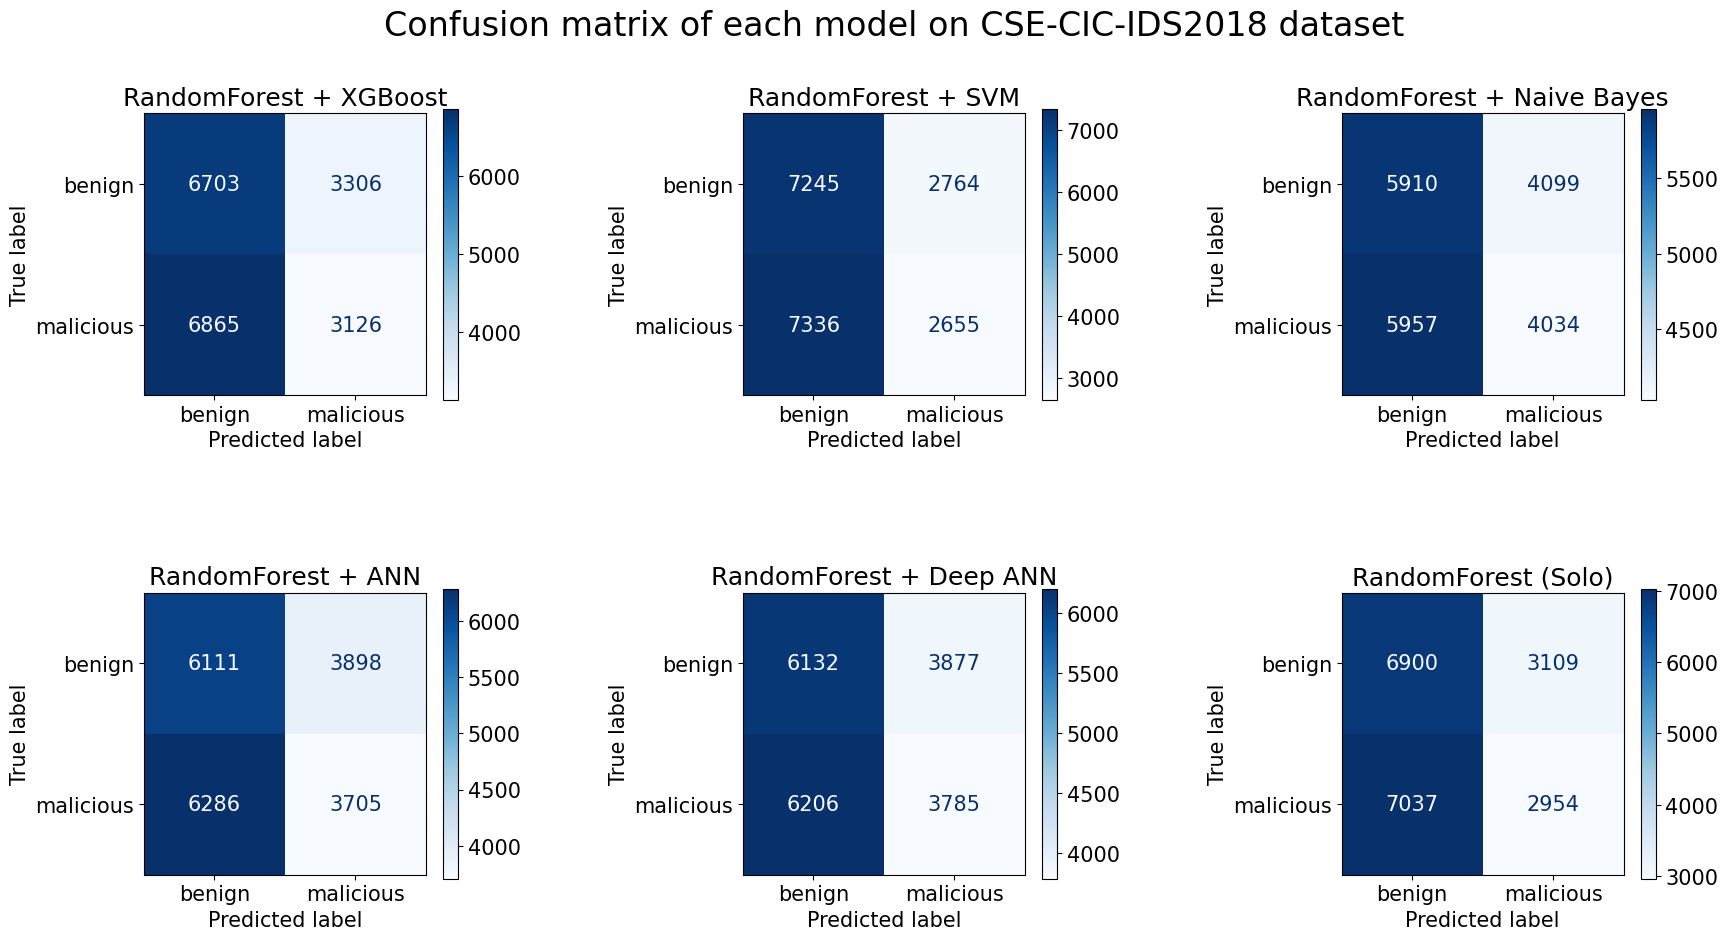


Thời gian dự đoán trên CSE-CIC-IDS2018 của từng mô hình:
RandomForest + XGBoost: 0.94 giây
RandomForest + SVM: 68.98 giây
RandomForest + Naive Bayes: 0.83 giây
RandomForest + ANN: 0.81 giây
RandomForest + Deep ANN: 1.28 giây
RandomForest (Solo): 1.48 giây


In [17]:
# Đóng tất cả các biểu đồ trước đó để tránh trùng lặp
plt.close('all')

# Khởi tạo các biến để lưu kết quả
prediction_time_2018 = {}
accuracy_testing_2018 = {}
f_score_testing_2018 = {}

# Tạo bố cục 2 hàng 3 cột để chứa 6 mô hình
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, (model, clf) in enumerate(trained_models.items()):
    # Đo thời gian dự đoán
    prediction_start_time = process_time()
    prediction = clf.predict(ids2018_X_scaled)
    prediction_time_2018[model] = process_time() - prediction_start_time

    # Tính toán báo cáo phân loại
    model_report = classification_report(ids2018_y, prediction, digits=4, output_dict=True)

    # Lưu accuracy và f1-score
    accuracy_testing_2018[model] = model_report['accuracy']
    f_score_testing_2018[model] = model_report['weighted avg']['f1-score']

    # In báo cáo phân loại
    print(f"{'-'*25} {model} {'-'*25}")
    print(classification_report(ids2018_y, prediction, digits=4))

    # Vẽ ma trận nhầm lẫn
    cm = confusion_matrix(ids2018_y, prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malicious'])
    disp.plot(ax=axes[math.floor(i/3)][i%3], cmap=plt.cm.Blues)
    axes[math.floor(i/3)][i%3].set_title(model)

# Điều chỉnh bố cục và thêm tiêu đề
fig.subplots_adjust(hspace=0.65, wspace=0.7)
fig.suptitle('Confusion matrix of each model on CSE-CIC-IDS2018 dataset', fontsize=24)

# Hiển thị hình
plt.show()

# In thời gian dự đoán của từng mô hình
print("\nThời gian dự đoán trên CSE-CIC-IDS2018 của từng mô hình:")
for model, time in prediction_time_2018.items():
    print(f"{model}: {time:.2f} giây")

### Bước 5: Vẽ biểu đồ so sánh accuracy trên CIC-IDS2017 và CSE-CIC-IDS2018

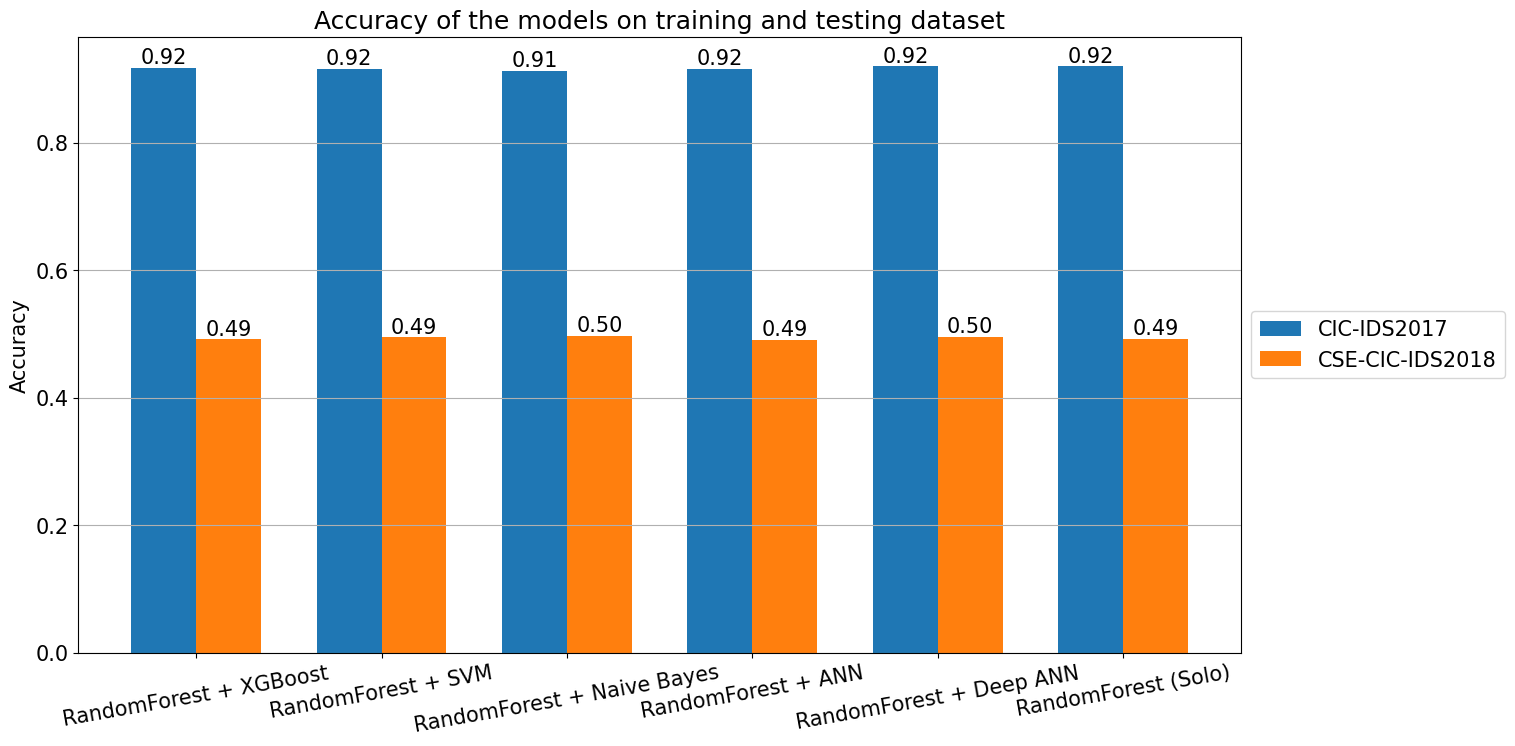

In [19]:
# Định nghĩa hàm để tạo nhãn trên đỉnh của các cột
def label_top(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height, f'{height:.2f}',
                 ha='center', va='bottom')

# Tạo biểu đồ
fig, ax = plt.subplots(figsize=(15, 8))
plt.rcParams.update({'font.size': 15})

# Số lượng mô hình và vị trí cột
x = np.arange(len(accuracy_testing_dataset.keys()))
width = 0.35  # Độ rộng của cột

# Vẽ cột cho CIC-IDS2017 (màu xanh)
bar1 = ax.bar(x - width/2, accuracy_testing_dataset.values(), width, label='CIC-IDS2017')

# Vẽ cột cho CSE-CIC-IDS2018 (màu cam)
bar2 = ax.bar(x + width/2, accuracy_testing_2018.values(), width, label='CSE-CIC-IDS2018')

# Đặt nhãn và tiêu đề
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of the models on training and testing dataset')
ax.set_xticks(x)
ax.set_xticklabels(accuracy_testing_dataset.keys(), rotation=10, horizontalalignment='center')
ax.grid(axis='y')

# Thêm legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Thêm nhãn trên đỉnh các cột
label_top(bar1)
label_top(bar2)

plt.show()

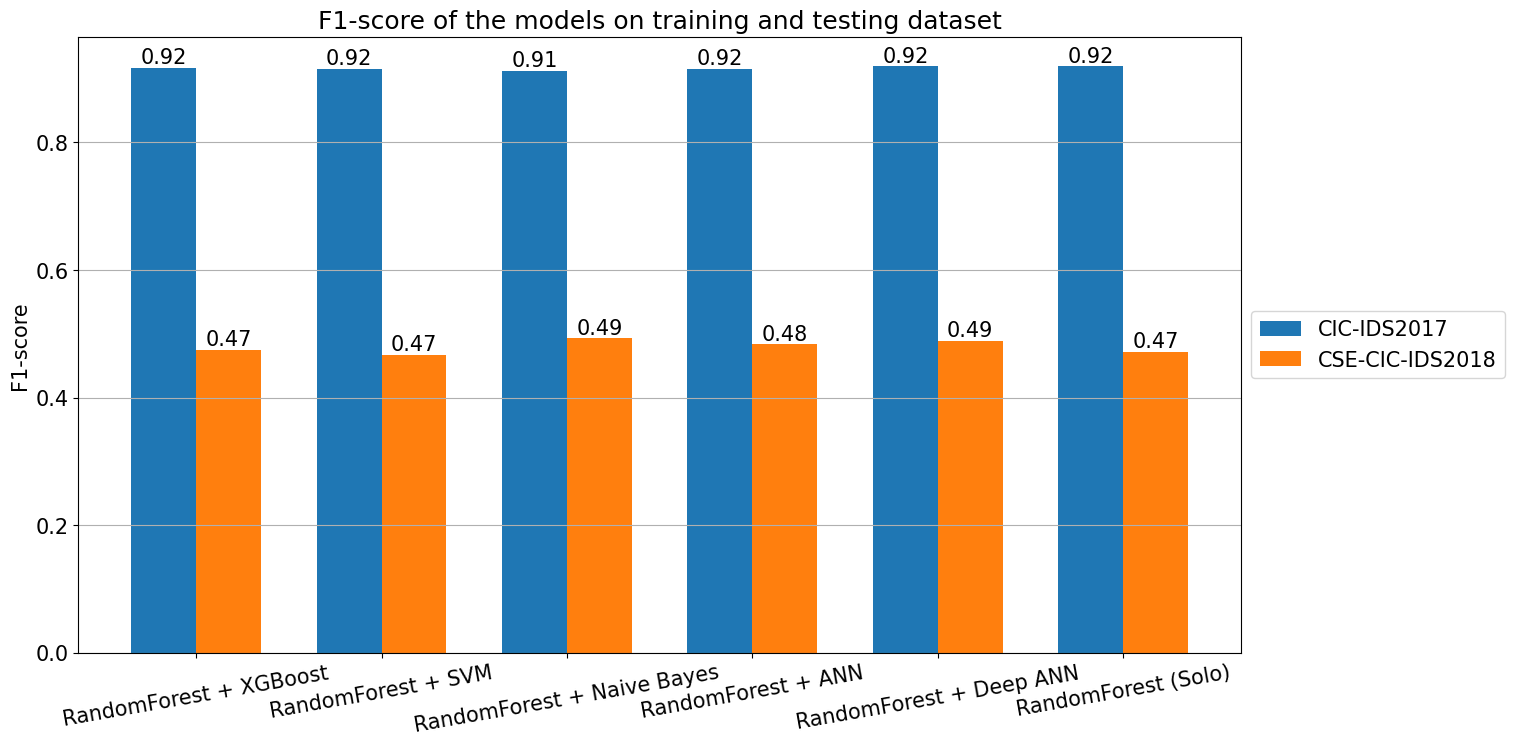

In [21]:
# Bước 6: Vẽ biểu đồ so sánh F1-score trên CIC-IDS2017 và CSE-CIC-IDS2018

# Định nghĩa hàm để tạo nhãn trên đỉnh của các cột
def label_top(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height, f'{height:.2f}',
                 ha='center', va='bottom')

# Tạo biểu đồ
fig, ax = plt.subplots(figsize=(15, 8))
plt.rcParams.update({'font.size': 15})

# Số lượng mô hình và vị trí cột
x = np.arange(len(f_score_testing_dataset.keys()))
width = 0.35  # Độ rộng của cột

# Vẽ cột cho CIC-IDS2017 (màu xanh)
bar1 = ax.bar(x - width/2, f_score_testing_dataset.values(), width, label='CIC-IDS2017')

# Vẽ cột cho CSE-CIC-IDS2018 (màu cam)
bar2 = ax.bar(x + width/2, f_score_testing_2018.values(), width, label='CSE-CIC-IDS2018')

# Đặt nhãn và tiêu đề
ax.set_ylabel('F1-score')
ax.set_title('F1-score of the models on training and testing dataset')
ax.set_xticks(x)
ax.set_xticklabels(f_score_testing_dataset.keys(), rotation=10, horizontalalignment='center')
ax.grid(axis='y')

# Thêm legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Thêm nhãn trên đỉnh các cột
label_top(bar1)
label_top(bar2)

plt.show()

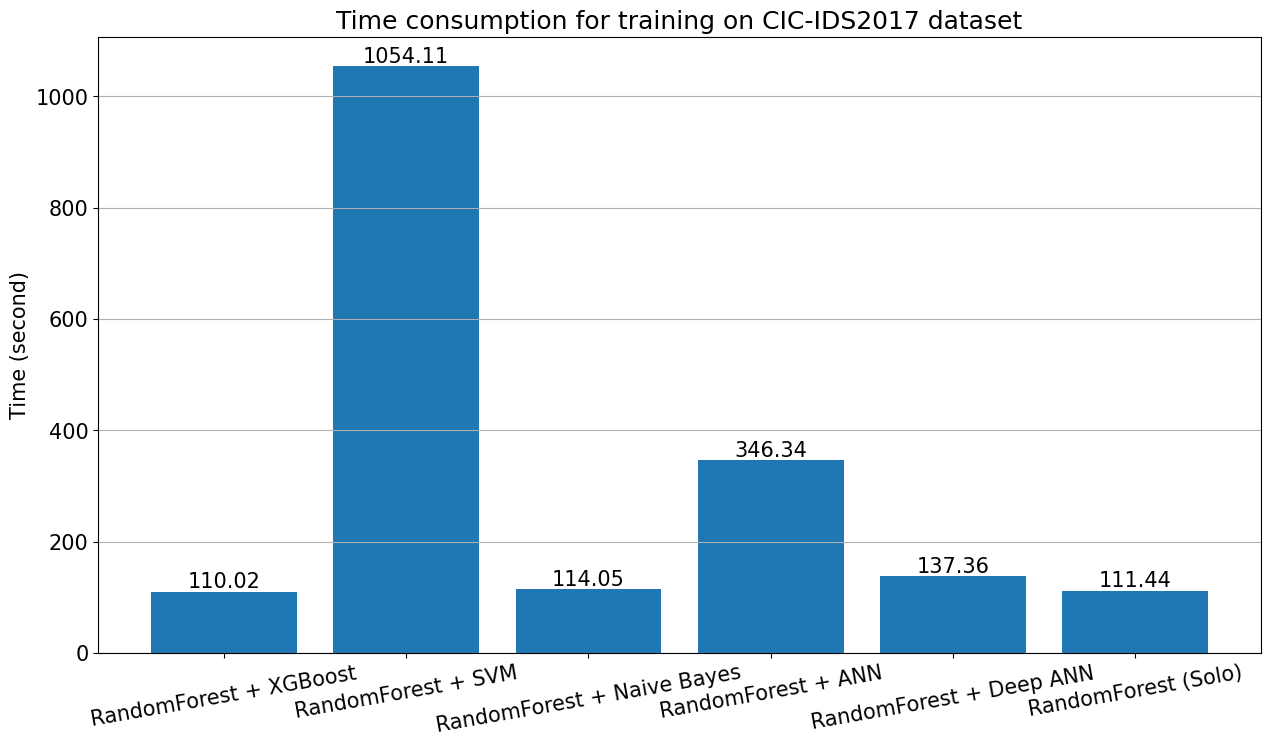

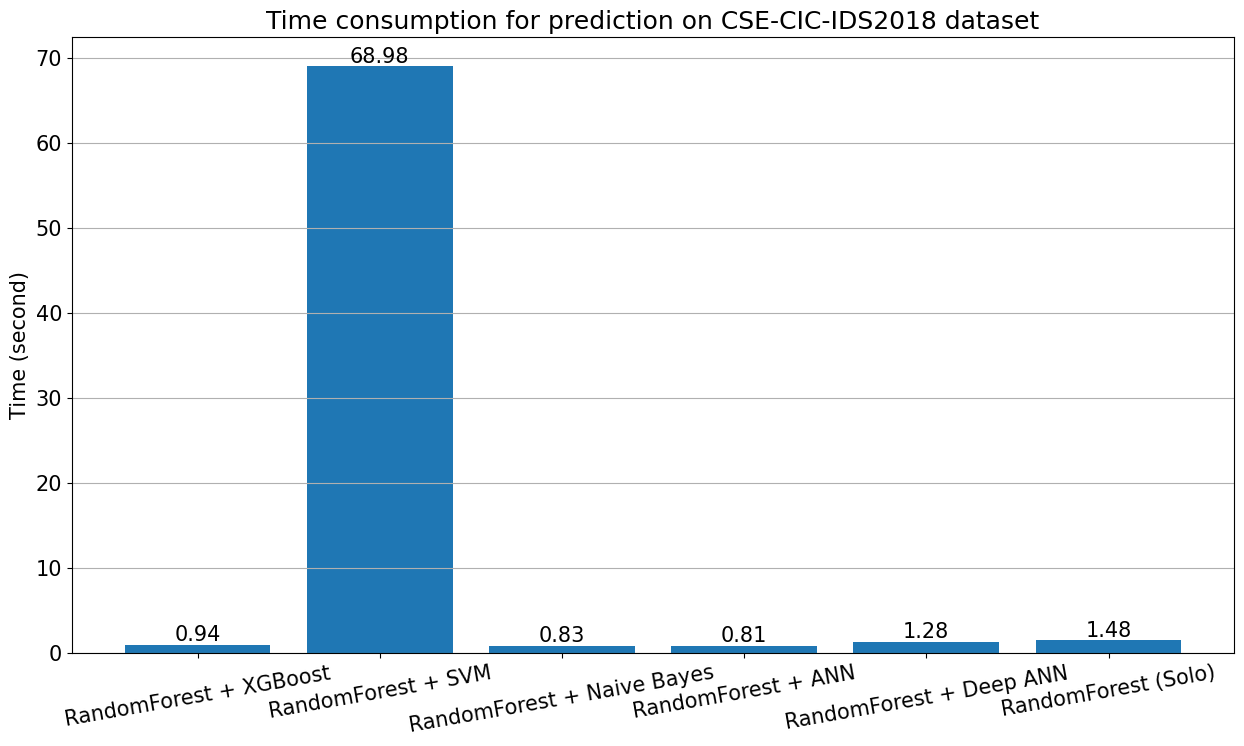

In [23]:
# Bước 7: Vẽ biểu đồ so sánh thời gian huấn luyện và dự đoán

# Định nghĩa hàm để tạo nhãn trên đỉnh của các cột
def label_top(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height, f'{height:.2f}',
                 ha='center', va='bottom')

# --- Biểu đồ 1: Thời gian huấn luyện trên CIC-IDS2017 ---
fig, ax = plt.subplots(figsize=(15, 8))
bar = ax.bar(training_time.keys(), training_time.values())
ax.set_ylabel('Time (second)')
ax.set_title('Time consumption for training on CIC-IDS2017 dataset')
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center')
ax.grid(axis='y')
label_top(bar)
plt.show()

# --- Biểu đồ 2: Thời gian dự đoán trên CSE-CIC-IDS2018 ---
fig, ax = plt.subplots(figsize=(15, 8))
bar = ax.bar(prediction_time_2018.keys(), prediction_time_2018.values())
ax.set_ylabel('Time (second)')
ax.set_title('Time consumption for prediction on CSE-CIC-IDS2018 dataset')
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center')
ax.grid(axis='y')
label_top(bar)
plt.show()